# 一、 应用机器学习的建议
### 1.1 模型评估

为了检验算法是否过拟合，我们将数据分成训练集和测试集，通常用70%的数据作为训练集，用剩下30%的数据作为测试集。

很重要的一点是训练集和测试集均要含有**各种类型的数据**，以保证测试的准确性。

测试集评估在通过训练集让我们的模型学习得出其参数后，对测试集运用该模型，我们有两种方式计算误差：

1. 对于线性回归模型，我们利用测试集数据计算代价函数$J$
2. 对于逻辑回归模型，我们除了可以利用测试数据集来计算代价函数外：

$$ 
J_{test}{(\theta)} = -\frac{1}{{m}_{test}}\sum _{i=1}^{m_{test}}{y^{(i)}}_{test}\log{h_{\theta}(x^{(i)}_{test})}+(1-{y^{(i)}_{test}})\log{h_{\theta}(x^{(i)}_{test})}
$$

误分类的比率，对于每一个测试集样本，计算预测的错误率
$$
\hat{y}=\left\{ \begin{matrix}
   1&if&{{f}_{\overrightarrow{w,}b}}({{\overrightarrow{x}}^{(i)}})\ge 0.5  \\
   0&if&{{f}_{\overrightarrow{w},b}}({{\overrightarrow{x}}^{(i)}})<0.5  \\
\end{matrix} \right.
$$

### 1.2 多项式模型选择

假设我们要在10个不同次数的二项式模型之间进行选择：

![](images/1b908480ad78ee54ba7129945015f87f.jpg)

显然越高次数的多项式模型越能够适应我们的训练数据集，但是适应训练数据集并不代表着能推广至一般情况，我们应该选择一个更能适应一般情况的模型。我们需要使用 **交叉验证集** 来帮助选择模型。
	
即：使用60%的数据作为训练集，使用 20%的数据作为交叉验证集（cross validation / development set），使用20%的数据作为测试集

模型选择的方法为：

1. 使用训练集训练出10个模型

2. 用10个模型分别对交叉验证集计算得出交叉验证误差（代价函数的值）

3. 选取代价函数值最小的模型

4. 用步骤3中选出的模型对测试集计算得出推广误差（代价函数的值）

   ***Train/validation/test error***

   **Training error:**

$J_{train}(\theta) = \frac{1}{2m}\sum_{i=1}^{m}(h_{\theta}(x^{(i)})-y^{(i)})^2$

**Cross Validation error:**

$J_{cv}(\theta) = \frac{1}{2m_{cv}}\sum_{i=1}^{m}(h_{\theta}(x^{(i)}_{cv})-y^{(i)}_{cv})^2$

**Test error:**

$J_{test}(\theta)=\frac{1}{2m_{test}}\sum_{i=1}^{m_{test}}(h_{\theta}(x^{(i)}_{test})-y^{(i)}_{test})^2$

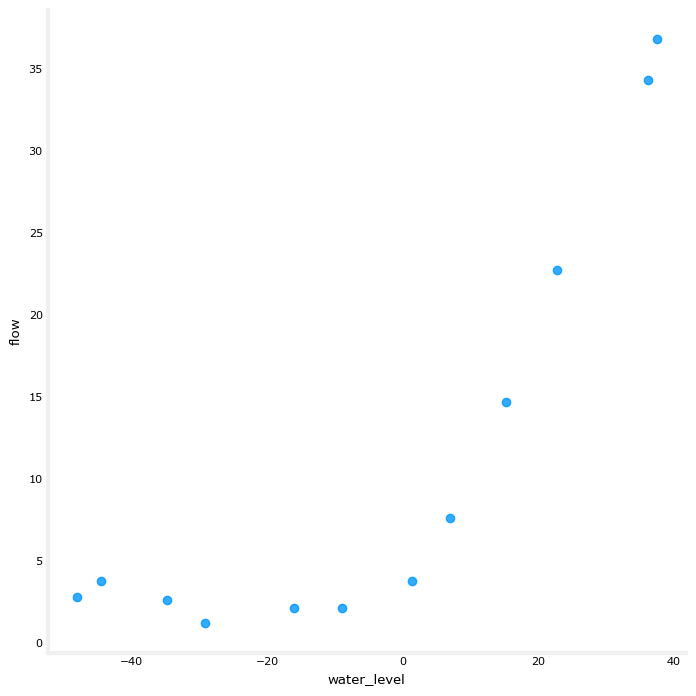

In [93]:
import numpy as np
import scipy.io as sio
import scipy.optimize as opt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('data/deeplearning.mplstyle')
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

def load_data():
    #d['X'] shape = (12, 1)  pandas在使用这个2d ndarray来构建数据框架时遇到了麻烦，所以我将结果拆开
    d = sio.loadmat('data/ex5data1.mat')
    return map(np.ravel, [d['X'], d['y'], d['Xval'], d['yval'], d['Xtest'], d['ytest']])
X, y, Xval, yval, Xtest, ytest = load_data()
df = pd.DataFrame({'water_level':X, 'flow':y})
sns.lmplot('water_level', 'flow', data=df, fit_reg=False, height=7)
plt.show()
X, Xval, Xtest = [np.insert(x.reshape(x.shape[0], 1), 0, np.ones(x.shape[0]), axis=1) for x in (X, Xval, Xtest)]

# 代价函数
def cost(theta, X, y):
    m = X.shape[0]
    inner = X @ theta - y  # R(m*1)
    square_sum = inner.T @ inner
    cost = square_sum / (2 * m)
    return cost
theta = np.ones(X.shape[1])
# 梯度
def gradient(theta, X, y):
    m = X.shape[0]
    inner = X.T @ (X @ theta - y)  # (m,n).T @ (m, 1) -> (n, 1)
    return inner / m
# 正则化梯度
def regularized_gradient(theta, X, y, l=1):
    m = X.shape[0]
    regularized_term = theta.copy()  # same shape as theta
    regularized_term[0] = 0  # don't regularize intercept theta
    regularized_term = (l / m) * regularized_term
    return gradient(theta, X, y) + regularized_term

### 1.3 偏差和方差

当你运行一个学习算法时，如果这个算法的表现不理想，那么多半是出现两种情况：要么是偏差(欠拟合)比较大，要么是方差(过拟合)比较大

![](images/p006.png)

我们通常会通过将训练集和交叉验证集的代价函数误差与多项式的次数绘制在同一张图表上来帮助分析：

![](images/p030.png)

**Training error:**				               
$$
J_{train}(\theta) = \frac{1}{2m}\sum_{i=1}^{m}(h_{\theta}(x^{(i)})-y^{(i)})^2
$$

**Cross Validation error:**				
$$
J_{cv}(\theta) = \frac{1}{2m_{cv}}\sum_{i=1}^{m}(h_{\theta}(x^{(i)}_{cv})-y^{(i)}_{cv})^2
$$

对于训练集，当 $d$ 较小时，模型拟合程度更低，误差较大；随着 $d$ 的增长，拟合程度提高，误差减小。
	
对于交叉验证集，当 $d$ 较小时，模型拟合程度低，误差较大；但是随着 $d$ 的增长，误差呈现先减小后增大的趋势，转折点是我们的模型开始过拟合训练数据集的时候。
	
如果我们的交叉验证集误差较大，我们如何判断是方差还是偏差呢？

- 训练集误差和交叉验证集误差近似时：偏差/欠拟合
- 交叉验证集误差远大于训练集误差时：方差/过拟合

神经网络的方差和偏差：
![](images/p031.png)

使用较小的神经网络，类似于参数较少的情况，容易导致高偏差和欠拟合，但计算代价较小使用较大的神经网络，类似于参数较多的情况，容易导致高方差和过拟合，虽然计算代价比较大，但是可以通过正则化手段来调整而更加适应数据。通常选择**较大的神经网络并采用正则化regularization**处理会比采用较小的神经网络效果要好。

### 1.4 正则化和偏差/方差

在我们在训练模型的过程中，一般会使用一些正则化方法来防止过拟合。但是我们可能会正则化的程度太高或太小了，即我们在选择λ的值时也需要思考与刚才选择多项式模型次数类似的问题。

![](images/p004.png)

我们选择一系列的想要测试的 $\lambda$ 值，通常是 0-10之间的呈现2倍关系的值（如：$0,0.01,0.02,0.04,0.08,0.15,0.32,0.64,1.28,2.56,5.12,10$共12个）。 我们同样把数据分为训练集、交叉验证集和测试集。

$$
\begin{align}
  & {{h}_{\theta }}(x)={{\theta }_{0}}+{{\theta }_{1}}x+{{\theta }_{2}}{{x}^{2}}+{{\theta }_{3}}{{x}^{3}}+{{\theta }_{4}}{{x}^{4}} \\ 
 & J(\theta )=\frac{1}{2m}\sum\limits_{i=1}^{m}{{{({{h}_{\theta }}({{x}^{(i)}})-{{y}^{(i)}})}^{2}}}+\frac{\lambda }{2m}\sum\limits_{j=1}^{m}{{{\theta }_{j}}^{2}} \\ 
\end{align}
$$
选择$\lambda$的方法为：

1. 使用训练集训练出12个不同程度正则化的模型
2. 用12个模型分别对交叉验证集计算的出交叉验证误差
3. 选择得出交叉验证误差**最小**的模型
4. 运用步骤3中选出模型对测试集计算得出推广误差

• 当 $\lambda$ 较小时，训练集误差较小（过拟合）而交叉验证集误差较大
• 随着 $\lambda$ 的增加，训练集误差不断增加（欠拟合），而交叉验证集误差则是先减小后增加

![](images/p005.png)

> 正则化拟合 $\lambda=0$

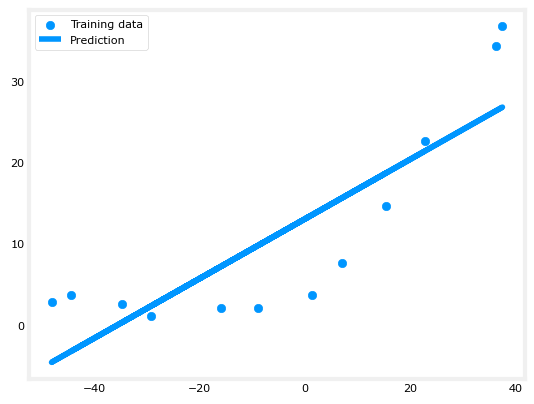

In [94]:
def regularized_cost(theta, X, y, l=1):
    m = X.shape[0]
    regularized_term = (l / (2 * m)) * np.power(theta[1:], 2).sum()
    return cost(theta, X, y) + regularized_term
# X: feature matrix, (m, n+1) # with incercept x0=1
# y: target vector, (m, )
# l: lambda constant for regularization
#  return: trained parameters
def linear_regression_np(X, y, l=1):
    # init theta
    theta = np.ones(X.shape[1])
    # train it
    res = opt.minimize(fun=regularized_cost,
        x0=theta,
        args=(X, y, l),
        method='TNC',
        jac=regularized_gradient,
        options={'disp': True})
    return res
theta = np.ones(X.shape[0])
final_theta = linear_regression_np(X, y, l=0).get('x')
b = final_theta[0] # intercept
m = final_theta[1] # slope
plt.scatter(X[:,1], y, label="Training data")
plt.plot(X[:, 1], X[:, 1]*m + b, label="Prediction")
plt.legend(loc=2)
plt.show()

### 1.5 学习曲线

学习曲线是将训练集误差和交叉验证集误差作为训练集样本数量（$m$）的函数绘制的图表。如果我们有100行数据，我们从1行数据开始，逐渐学习更多行的数据。思想是：当训练较少行数据的时候，训练的模型将能够非常完美地适应较少的训练数据，但是训练出来的模型却不能很好地适应交叉验证集数据或测试集数据。

如何利用学习曲线识别高偏差/欠拟合：作为例子，我们尝试用一条直线来适应下面的数据，可以看出，无论训练集有多么大误差都不会有太大改观,也就是说在高偏差/欠拟合的情况下，增加数据到训练集不一定能有帮助。

<img src="images/p002.png" style="zoom:50%;" />
	
如何利用学习曲线识别高方差/过拟合：假设我们使用一个非常高次的多项式模型，并且正则化非常小，可以看出，当交叉验证集误差远大于训练集误差时，往训练集增加更多数据可以提高模型的效果,也就是说在高方差/过拟合的情况下，增加更多数据到训练集可能可以提高算法效果。

![](images/p001.png)



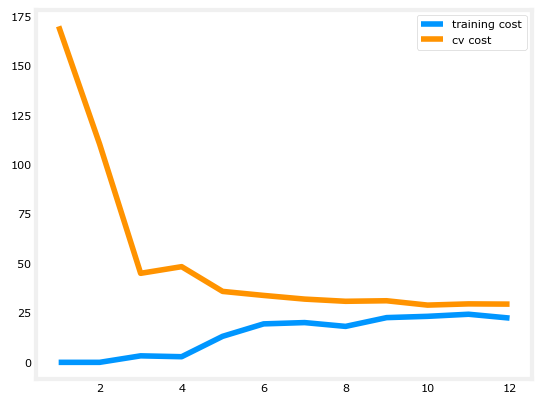

In [95]:
# 一下计算交叉验证，没有正则化，仅仅使用训练集的子集来拟合模型
m = X.shape[0]
training_cost, cv_cost = [], []
for i in range(1, m+1):
    res = linear_regression_np(X[:i, :], y[:i], l=0)
    tc = regularized_cost(res.x, X[:i, :], y[:i], l=0)
    cv = regularized_cost(res.x, Xval, yval, l=0)
    training_cost.append(tc)
    cv_cost.append(cv)
plt.plot(np.arange(1, m+1), training_cost, label='training cost')
plt.plot(np.arange(1, m+1), cv_cost, label='cv cost')
plt.legend(loc=1)
plt.show()
# 可以发现，该模型欠拟合了

### 1.6 改进模型

1. 获得更多的训练样本——解决高方差

2. 尝试减少特征的数量——解决高方差

3. 尝试获得更多的特征——解决高偏差

4. 尝试增加多项式特征——解决高偏差

5. 尝试减少正则化程度λ——解决高偏差

6. 尝试增加正则化程度λ——解决高方差

> 扩展为多项式后，尝试不同 $\lambda$ 并选择最优的 $\lambda$

In [96]:
def normalize_feature(df):
    return df.apply(lambda column: (column - column.mean()) / column.std())
    
def poly_features(x, power, as_ndarray=False):
    data = {'f{}'.format(i): np.power(x, i) for i in range(1, power + 1)}
    df = pd.DataFrame(data)
    return df.values if as_ndarray else df
    
def prepare_poly_data(*args, power):
    def prepare(x):
        # expand feature
        df = poly_features(x, power=power)
        # normalization
        ndarr = normalize_feature(df).values  # 注意此处应该为values,而非values()
        # add intercept term
        return np.insert(ndarr, 0, np.ones(ndarr.shape[0]), axis=1)
    return [prepare(x) for x in args]

def plot_learning_curve(X, y, Xval, yval, l=0):
    training_cost, cv_cost = [], []
    m = X.shape[0]
    for i in range(1, m + 1):
        # regularization applies here for fitting parameters
        res = linear_regression_np(X[:i, :], y[:i], l=l)
        # remember, when you compute the cost here, you are computing
        # non-regularized cost. Regularization is used to fit parameters only
        tc = cost(res.x, X[:i, :], y[:i])
        cv = cost(res.x, Xval, yval)
        training_cost.append(tc)
        cv_cost.append(cv)
    plt.plot(np.arange(1, m + 1), training_cost, label='training cost')
    plt.plot(np.arange(1, m + 1), cv_cost, label='cv cost')
    plt.legend(loc=1)

X, y, Xval, yval, Xtest, ytest = load_data()
# 扩展成了8阶多项式
X_poly, Xval_poly, Xtest_poly= prepare_poly_data(X, Xval, Xtest, power=8)  

# 画出学习曲线
> 没有使用正则化，所以 $\lambda=0$         可以看到训练的代价太低了，不真实. 这是 **过拟合**了

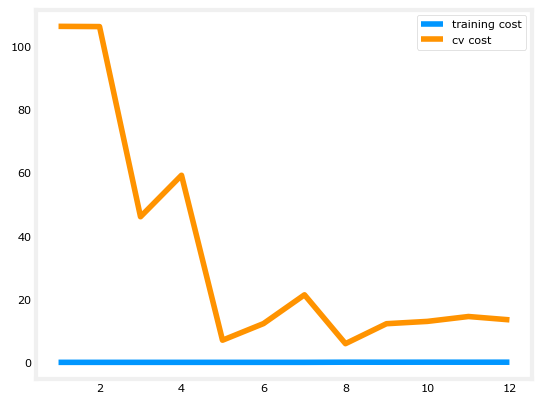

In [97]:
plot_learning_curve(X_poly, y, Xval_poly, yval, l=0)
plt.show()

> try $\lambda=1$      训练代价增加了些，不再是0了减轻**过拟合**

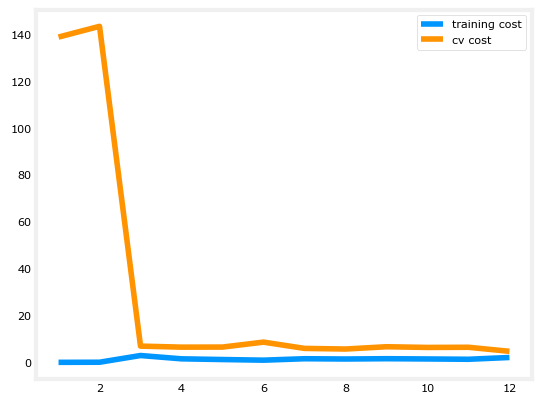

In [98]:
plot_learning_curve(X_poly, y, Xval_poly, yval, l=1)
plt.show()

> try $\lambda=100$  变成 **欠拟合**状态

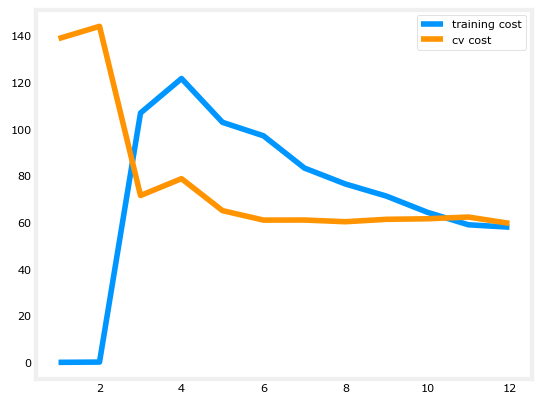

In [99]:
plot_learning_curve(X_poly, y, Xval_poly, yval, l=100)
plt.show()

> 找到最佳的 $\lambda$

In [100]:
l_candidate = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
training_cost, cv_cost = [], []

In [101]:
for l in l_candidate:
    res = linear_regression_np(X_poly, y, l)
    
    tc = cost(res.x, X_poly, y)
    cv = cost(res.x, Xval_poly, yval)
    
    training_cost.append(tc)
    cv_cost.append(cv)

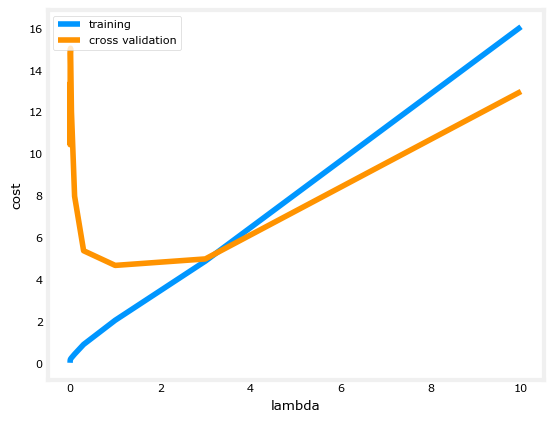

In [102]:
plt.plot(l_candidate, training_cost, label='training')
plt.plot(l_candidate, cv_cost, label='cross validation')
plt.legend(loc=2)

plt.xlabel('lambda')

plt.ylabel('cost')
plt.show()

In [103]:
# best cv I got from all those candidates
l_candidate[np.argmin(cv_cost)]
# use test data to compute the cost
for l in l_candidate:
    theta = linear_regression_np(X_poly, y, l).x
    print('test cost(l={}) = {}'.format(l, cost(theta, Xtest_poly, ytest)))

test cost(l=0) = 10.02464287753563
test cost(l=0.001) = 11.03989643825398
test cost(l=0.003) = 11.263612931846453
test cost(l=0.01) = 10.87954944353898
test cost(l=0.03) = 10.022095688423208
test cost(l=0.1) = 8.632065168219597
test cost(l=0.3) = 7.336723122820889
test cost(l=1) = 7.466289574046468
test cost(l=3) = 11.643928179962794
test cost(l=10) = 27.715080206181412


调参后， $\lambda = 0.3$ 是最优选择，这个时候测试代价最小

二、机器学习系统的设计
--------------------------------------------------------

### 2.1  类偏斜的误差度量

Error Metrics for Skewed Classes 

类偏斜情况表现为我们的训练集中有非常多的同一种类的样本，只有很少或没有其他类的样本
	
	
**查准率**（**Precision**）和**查全率**（**Recall**） 我们将算法预测的结果分成四种情况：
	

1. **正确肯定**（**True Positive,TP**）：预测为真，实际为真

2. **正确否定**（**True Negative,TN**）：预测为假，实际为假
​	
3. **错误肯定**（**False Positive,FP**）：预测为真，实际为假
​	
4. **错误否定**（**False Negative,FN**）：预测为假，实际为真

则：查准率=**TP/(TP+FP)** ，越高越好。
	
查全率=**TP/(TP+FN)** ，越高越好。
	
这样，对于我们刚才那个总是预测病人肿瘤为良性的算法，其查全率是0

|            |              | **预测值**   |             |
| ---------- | ------------ | ------------ | ----------- |
|            |              | **Positive** | **Negtive** |
| **实际值** | **Positive** | **TP**       | **FN**      |
|            | **Negtive**  | **FP**       | **TN**      |

### 2.2  查准率和查全率之间的权衡

可以通过调整阈值来使查准率和查全率变化。将不同阀值情况下，查全率与查准率的关系绘制成图表，曲线的形状根据数据的不同而不同：

![](images/p003.png)

我们希望有一个帮助我们选择这个阀值的方法。一种方法是计算**F1 值**（**F1 Score**），选择使得**F1**值最高的阀值：

$$
{{F}_{1}}Score:2\frac{PR}{P+R}
$$